In [1]:
# Load packages (Likely not all needed)

In [3]:
import geopandas as gpd
import numpy as np
import os
import sys
import glob
from copy import deepcopy
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap
from matplotlib import cm

import pickle

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import seaborn as sns
import shapely

from climada.util import coordinates as u_coords
from climada.hazard import Hazard
from climada_petals.engine.networks.nw_base import Network
from climada_petals.engine.networks.nw_calcs import Graph

import analysis.analysis_funcs as af
import analysis.plotting_funcs as pf

os.chdir('/cluster/project/climate/evelynm/mplotutils') 
import mplotutils as mpu

### Define Averaging Functions

In [4]:
def flatten_comprehension(matrix):
     return [item for row in matrix for item in row]

def get_fail_mech_health(gdf_imps, ci_graph):
    # for a single event, get the distribution of failure mechanisms
    
    # population vertices in orig. graph that are out of service access
    v_ids_affected = gdf_imps[(gdf_imps.ci_type=='people')&(gdf_imps.actual_supply_health_people==-1)]['v_id']
    v_affected = ci_graph.graph.vs[v_ids_affected]
    
    # healthcare vertices in orig. graph that were initially supplying these population vertices
    v_ids_health = [[v['name'] for v in v_aff.neighbors('in') if v['ci_type']=='health'] for v_aff in v_affected]
    
    # Reason for failure (casc. state)
    dict_casc_state_health = dict(zip(gdf_imps[gdf_imps.ci_type=='health']['v_id'].values,
                                      gdf_imps[gdf_imps.ci_type=='health']['casc_state'].values))
    fail_reason_health = [[dict_casc_state_health[v] for v in v_id_health] 
                          for v_id_health in v_ids_health]
    
    # weight failure mech. by number of people affected
    weight_matrix = [[1/len(facs)*count]*len(facs) for count, facs in zip(v_affected['counts'], v_ids_health)]
    
    # summarize results
    df_fail_mech = pd.DataFrame()
    df_fail_mech['weight'] = flatten_comprehension(weight_matrix)
    df_fail_mech['mech'] = flatten_comprehension(fail_reason_health)
    
    df_fail_mech = df_fail_mech.groupby('mech').sum().rename({'weight' : 'health'}, axis=1)/df_fail_mech['weight'].sum()
    
    # return summary df and total affected for weighting across events afterwards
    return df_fail_mech, np.array(v_affected['counts']).sum()

def get_fail_mech_educ(gdf_imps, ci_graph):
    # for a single event, get the distribution of failure mechanisms

    # population vertices in orig. graph that are out of service access
    v_ids_affected = gdf_imps[(gdf_imps.ci_type=='people')&(gdf_imps.actual_supply_education_people==-1)]['v_id']
    v_affected = ci_graph.graph.vs[v_ids_affected]
    
    # education vertices in orig. graph that were initially supplying these population vertices
    v_ids_educ = [[v['name'] for v in v_aff.neighbors('in') if v['ci_type']=='education'] for v_aff in v_affected]
    
    # Reason for failure (casc. state)
    dict_casc_state_educ = dict(zip(gdf_imps[gdf_imps.ci_type=='education']['v_id'].values,
                                    gdf_imps[gdf_imps.ci_type=='education']['casc_state'].values))
    fail_reason_educ = [[dict_casc_state_educ[v] for v in v_id_educ] 
                          for v_id_educ in v_ids_educ]
    
    # weight failure mech. by number of people affected
    weight_matrix = [[1/len(facs)*count]*len(facs) for count, facs in zip(v_affected['counts'], v_ids_educ)]
    
    # summarize results
    df_fail_mech = pd.DataFrame()
    df_fail_mech['weight'] = flatten_comprehension(weight_matrix)
    df_fail_mech['mech'] = flatten_comprehension(fail_reason_educ)
    df_fail_mech = df_fail_mech.groupby('mech').sum().rename({'weight' : 'education'}, axis=1)/df_fail_mech['weight'].sum()
    
    # return summary df and total affected for weighting across events afterwards
    return df_fail_mech, np.array(v_affected['counts']).sum()

def get_fail_mech_pow(gdf_imps, ci_graph):
    
    # population vertices in orig. graph that are out of service access
    v_ids_affected = gdf_imps[(gdf_imps.ci_type=='people')&(gdf_imps.actual_supply_power_line_people==-1)]['v_id']
    v_affected = ci_graph.graph.vs[v_ids_affected]
    
    # power vertices in orig. graph that were initially supplying these population vertices
    v_ids_educ = [[v['name'] for v in v_aff.neighbors('in') if v['ci_type']=='power_line'] for v_aff in v_affected]
    
    # Reason for failure (casc. state)
    dict_casc_state_educ = dict(zip(gdf_imps[gdf_imps.ci_type=='power_line']['v_id'].values,
                                      gdf_imps[gdf_imps.ci_type=='power_line']['casc_state'].values))
    fail_reason_educ = [[dict_casc_state_educ[v] for v in v_id_educ] 
                          for v_id_educ in v_ids_educ]
    
    # weight failure mech. by number of people affected
    weight_matrix = [[1/len(facs)*count]*len(facs) for count, facs in zip(v_affected['counts'], v_ids_educ)]
    
    # summarize results
    df_fail_mech = pd.DataFrame()
    df_fail_mech['weight'] = flatten_comprehension(weight_matrix)
    df_fail_mech['mech'] = flatten_comprehension(fail_reason_educ)
    df_fail_mech['mech'] = df_fail_mech['mech'].replace(0, 3)  # mechanism '0' in case of power grid not consistent with '0' of other mechanisms -> rename to 3
    df_fail_mech = df_fail_mech.groupby('mech').sum().rename({'weight' : 'power'}, axis=1)/df_fail_mech['weight'].sum()
    
    # return summary df and total affected for weighting across events afterwards
    return df_fail_mech, np.array(v_affected['counts']).sum()


def get_fail_mech_ct(gdf_imps, ci_graph):
    
    # population vertices in orig. graph that are out of service access
    v_ids_affected = gdf_imps[(gdf_imps.ci_type=='people')&(gdf_imps.actual_supply_celltower_people==-1)]['v_id']
    v_affected = ci_graph.graph.vs[v_ids_affected]
    
    # power vertices in orig. graph that were initially supplying these population vertices
    v_ids_educ = [[v['name'] for v in v_aff.neighbors('in') if v['ci_type']=='celltower'] for v_aff in v_affected]
    
    # Reason for failure (casc. state)
    dict_casc_state_educ = dict(zip(gdf_imps[gdf_imps.ci_type=='celltower']['v_id'].values,
                                      gdf_imps[gdf_imps.ci_type=='celltower']['casc_state'].values))
    fail_reason_educ = [[dict_casc_state_educ[v] for v in v_id_educ] 
                          for v_id_educ in v_ids_educ]
    
    # weight failure mech. by number of people affected
    weight_matrix = [[1/len(facs)*count]*len(facs) for count, facs in zip(v_affected['counts'], v_ids_educ)]
    
    # summarize results
    df_fail_mech = pd.DataFrame()
    df_fail_mech['weight'] = flatten_comprehension(weight_matrix)
    df_fail_mech['mech'] = flatten_comprehension(fail_reason_educ)
    df_fail_mech = df_fail_mech.groupby('mech').sum().rename({'weight' : 'ct'}, axis=1)/df_fail_mech['weight'].sum()
    
    # return summary df and total affected for weighting across events afterwards
    return df_fail_mech, np.array(v_affected['counts']).sum()

def get_all_mechs_all(gdf_imp, ci_graph):
    df_h, w_h = get_fail_mech_health(gdf_imp, ci_graph)
    df_e, w_e = get_fail_mech_educ(gdf_imp, ci_graph)
    df_p, w_p = get_fail_mech_pow(gdf_imp, ci_graph)
    df_c, w_c = get_fail_mech_ct(gdf_imp, ci_graph)
    
    df_all_failmechs = pd.concat([df_h, df_e, df_p, df_c], axis=1).fillna(0)
    # check that all categories (0, 1, 2, 3) are part of index, else add.
    for ix in [0,1,2,3]:
        if ix not in df_all_failmechs.index:   
            df_all_failmechs.loc[ix] = [0]*len(df_all_failmechs.columns)

    return [w_h, w_e, w_p, w_c], df_all_failmechs.sort_index()


## Define spatially resolved functions

In [5]:
def get_fail_mech_health_spatial(gdf_imps, ci_graph):
    # for a single event, get the distribution of failure mechanisms
    
    # population vertices in orig. graph that are out of service access
    v_ids_affected = gdf_imps[(gdf_imps.ci_type=='people')&(gdf_imps.actual_supply_health_people==-1)]['v_id']
    v_affected = ci_graph.graph.vs[v_ids_affected]
    
    # healthcare vertices in orig. graph that were initially supplying these population vertices
    v_ids_health = [[v['name'] for v in v_aff.neighbors('in') if v['ci_type']=='health'] for v_aff in v_affected]
    
    # Reason for failure (casc. state)
    dict_casc_state_health = dict(zip(gdf_imps[gdf_imps.ci_type=='health']['v_id'].values,
                                      gdf_imps[gdf_imps.ci_type=='health']['casc_state'].values))
    fail_reason_health = [[dict_casc_state_health[v] for v in v_id_health] 
                          for v_id_health in v_ids_health]
    
    # if several failure mechs, take the one most often relevant for this cluster
    fail_reason_health = [max(fails, key=fails.count) for fails in fail_reason_health]
 
    # summarize results
    gdf_fail_mech = gpd.GeoDataFrame()
    gdf_fail_mech['geometry'] = gdf_imps[(gdf_imps.ci_type=='people')&(gdf_imps.actual_supply_health_people==-1)]['geometry']
    gdf_fail_mech['mech'] = fail_reason_health
    
    # add those who never had access and mark with 4
    no_acc = gpd.GeoDataFrame(gdf_imps[(gdf_imps.ci_type=='people')&(gdf_imps.actual_supply_health_people==0)]['geometry'])
    return gdf_fail_mech.append(no_acc).fillna(4)

def get_fail_mech_educ_spatial(gdf_imps, ci_graph):
    # for a single event, get the distribution of failure mechanisms

    # population vertices in orig. graph that are out of service access
    v_ids_affected = gdf_imps[(gdf_imps.ci_type=='people')&(gdf_imps.actual_supply_education_people==-1)]['v_id']
    v_affected = ci_graph.graph.vs[v_ids_affected]
    
    # education vertices in orig. graph that were initially supplying these population vertices
    v_ids_educ = [[v['name'] for v in v_aff.neighbors('in') if v['ci_type']=='education'] for v_aff in v_affected]
    
    # Reason for failure (casc. state)
    dict_casc_state_educ = dict(zip(gdf_imps[gdf_imps.ci_type=='education']['v_id'].values,
                                    gdf_imps[gdf_imps.ci_type=='education']['casc_state'].values))
    fail_reason_educ = [[dict_casc_state_educ[v] for v in v_id_educ] 
                          for v_id_educ in v_ids_educ]
    
    # if several failure mechs, take the one most often relevant for this cluster
    fail_reason_educ = [max(fails, key=fails.count) for fails in fail_reason_educ]
 
    # summarize results
    gdf_fail_mech = gpd.GeoDataFrame()
    gdf_fail_mech['geometry'] = gdf_imps[(gdf_imps.ci_type=='people')&(gdf_imps.actual_supply_education_people==-1)]['geometry']
    gdf_fail_mech['mech'] = fail_reason_educ
    # add those who never had access and mark with 4
    no_acc = gpd.GeoDataFrame( gdf_imps[(gdf_imps.ci_type=='people')&(gdf_imps.actual_supply_education_people==0)]['geometry'])
    return gdf_fail_mech.append(no_acc).fillna(4)

def get_fail_mech_pow_spatial(gdf_imps, ci_graph):
    
    # population vertices in orig. graph that are out of service access
    v_ids_affected = gdf_imps[(gdf_imps.ci_type=='people')&(gdf_imps.actual_supply_power_line_people==-1)]['v_id']
    v_affected = ci_graph.graph.vs[v_ids_affected]
    
    # power vertices in orig. graph that were initially supplying these population vertices
    v_ids_educ = [[v['name'] for v in v_aff.neighbors('in') if v['ci_type']=='power_line'] for v_aff in v_affected]
    
    # Reason for failure (casc. state)
    dict_casc_state_educ = dict(zip(gdf_imps[gdf_imps.ci_type=='power_line']['v_id'].values,
                                      gdf_imps[gdf_imps.ci_type=='power_line']['casc_state'].values))
    
    fail_reason_educ = [[dict_casc_state_educ[v] for v in v_id_educ] 
                          for v_id_educ in v_ids_educ]
    
    # if several failure mechs, take the one most often relevant for this cluster
    fail_reason_educ = [max(fails, key=fails.count) for fails in fail_reason_educ]

    # summarize results
    gdf_fail_mech = gpd.GeoDataFrame()
    gdf_fail_mech['geometry'] = gdf_imps[(gdf_imps.ci_type=='people')&(gdf_imps.actual_supply_power_line_people==-1)]['geometry']
    gdf_fail_mech['mech'] = fail_reason_educ
    gdf_fail_mech['mech'] = gdf_fail_mech['mech'].replace(0, 3)  # mechanism '0' in case of power grid not consistent with '0' of other mechanisms -> rename to 3
    no_acc = gpd.GeoDataFrame( gdf_imps[(gdf_imps.ci_type=='people')&(gdf_imps.actual_supply_power_line_people==0)]['geometry'])
    return gdf_fail_mech.append(no_acc).fillna(4)


def get_fail_mech_ct_spatial(gdf_imps, ci_graph):
    
    # population vertices in orig. graph that are out of service access
    v_ids_affected = gdf_imps[(gdf_imps.ci_type=='people')&(gdf_imps.actual_supply_celltower_people==-1)]['v_id']
    v_affected = ci_graph.graph.vs[v_ids_affected]
    
    # power vertices in orig. graph that were initially supplying these population vertices
    v_ids_educ = [[v['name'] for v in v_aff.neighbors('in') if v['ci_type']=='celltower'] for v_aff in v_affected]
    
    # Reason for failure (casc. state)
    dict_casc_state_educ = dict(zip(gdf_imps[gdf_imps.ci_type=='celltower']['v_id'].values,
                                      gdf_imps[gdf_imps.ci_type=='celltower']['casc_state'].values))
    fail_reason_educ = [[dict_casc_state_educ[v] for v in v_id_educ] 
                          for v_id_educ in v_ids_educ]
    
    # if several failure mechs, take the one most often relevant for this cluster
    fail_reason_educ = [max(fails, key=fails.count) for fails in fail_reason_educ]
 
    # summarize results
    gdf_fail_mech = gpd.GeoDataFrame()
    gdf_fail_mech['geometry'] = gdf_imps[(gdf_imps.ci_type=='people')&(gdf_imps.actual_supply_celltower_people==-1)]['geometry']
    gdf_fail_mech['mech'] = fail_reason_educ
    # add those who never had access and mark with 4
    no_acc = gpd.GeoDataFrame( gdf_imps[(gdf_imps.ci_type=='people')&(gdf_imps.actual_supply_celltower_people==0)]['geometry'])
    return gdf_fail_mech.append(no_acc).fillna(4)

## Define computation routine for all events across a region

In [6]:
def wrapper_avg_failmech(cntry, state=None, haz_type='TC', weight='equal'):
    """
    average service failure mechanisms over all events, weighted either equally between all events
    or by amount of affected population
    """
    
    # Variable definitions
    iso3 = u_coords.country_to_iso(cntry)

    # paths
    PATH_ROOT = '/cluster/work/climate/evelynm/nw_outputs/'
    path_cntry_folder = PATH_ROOT+f'{iso3}/'
    if state is not None:
        path_cntry_folder+=f'{state}/'
    path_nodes = path_cntry_folder+'cis_nw_nodes'
    path_edges = path_cntry_folder+'cis_nw_edges'
    
    # load base network & graph
    ci_network = Network(edges=gpd.read_feather(path_edges), 
                         nodes=gpd.read_feather(path_nodes))
    ci_graph = Graph(ci_network, directed=True)
    
    # read in all result gdfs
    if haz_type =='TC':
        paths_result_files = [file for file in glob.glob(path_cntry_folder +'cascade_results*') 
                                  if not 'DFO' in file]
    else: 
        paths_result_files = [file for file in glob.glob(path_cntry_folder +'cascade_results_DFO*')]
        
    gdf_list= []
    name_list = []
    for file_path in paths_result_files:
        event_name = file_path.split('_')[-1] if haz_type in ['TC', 'RF'] else 'DFO_'+ file_path.split('_')[-1]
        name_list.append(event_name)
        gdf_imp = gpd.read_feather(file_path)
        if 'casc_state' not in gdf_imp.columns:
            print(f'Casc state not computed for event {event_name}')
            af.get_casc_and_access_states(gdf_imp, ci_network.nodes, save_path=file_path)
        gdf_list.append(gdf_imp) 
    
    # get failure mechanisms for all services for all events
    dict_fail_mechs = {}
    dict_weights = {}
    
    for gdf_imp, event in zip(gdf_list, name_list):
        gdf_imp = gdf_imp.reset_index().rename({'index':'v_id'}, axis=1)
        dict_weights[event], dict_fail_mechs[event] = get_all_mechs_all(gdf_imp, ci_graph)

    # average over events
    df_concat = pd.concat(list(dict_fail_mechs.values()), axis=1)
    weight_matrix = np.array(list(dict_weights.values()))
    weight_matrix+=1 # to avoid zero division error (doesnt matter anyways for average)

    if df_concat.size<=16: #only 1 event
        df_avg_failmech = df_concat
    else:
        if weight=='equal':
            df_avg_failmech = pd.concat([
                pd.DataFrame(df_concat['health'].mean(axis=1), columns=['health']),
                pd.DataFrame(df_concat['education'].mean(axis=1), columns=['education']),
                pd.DataFrame(df_concat['power'].mean(axis=1), columns=['power']),
                pd.DataFrame(df_concat['ct'].mean(axis=1), columns=['ct']),
            ], axis=1)

        elif weight=='prop':
            # hardcoded position of weight_matrix according to order in get_all_mechs_all
            df_avg_failmech = pd.concat([
                pd.DataFrame(np.average(df_concat['health'],weights=np.array([weight_matrix[:,0]]*4), axis=1), columns=['health']),
                pd.DataFrame(np.average(df_concat['education'],weights=np.array([weight_matrix[:,1]]*4), axis=1), columns=['education']),
                pd.DataFrame(np.average(df_concat['power'],weights=np.array([weight_matrix[:,2]]*4), axis=1), columns=['power']),
                pd.DataFrame(np.average(df_concat['ct'],weights=np.array([weight_matrix[:,3]]*4), axis=1), columns=['ct']),      
            ], axis=1)
    
    # rename df
    dict_failmech = {
        0 : 'phys. access',
        1 : 'dir. damage',
        2 : 'casc. failure',
        3 : 'capa. failure'
    }

    # rename indices from 0-3 into more descriptive failure mechanisms (for better plotting)
    df_avg_failmech = df_avg_failmech.reset_index().rename({'index':'ind', 'mech':'ind'}, axis=1)
    df_avg_failmech['fail_mech'] = df_avg_failmech.apply(lambda row: dict_failmech[row.ind], axis=1)
    df_avg_failmech = df_avg_failmech.set_index('fail_mech')
    df_avg_failmech = df_avg_failmech.drop(['ind'], axis=1)
    
    return df_avg_failmech

In [7]:
# Plot disruption reasons onto population map


In [7]:
def _get_extent(gdf):
        buffer_deg = 0.1
        sub_gdf = gdf[gdf.geometry.type == 'Point']
        return (min(sub_gdf.geometry.x)-buffer_deg, max(sub_gdf.geometry.x)+buffer_deg,
                         min(sub_gdf.geometry.y)-buffer_deg, max(sub_gdf.geometry.y)+buffer_deg)


In [8]:
def plot_spatial_failmechs(gdf_fail, gdf_whole, service, event_name=None, save_path=None):
    
    border = cfeature.NaturalEarthFeature('cultural', 'admin_0_countries', '50m')
    f, ax = plt.subplots(1,1, subplot_kw=dict(projection=ccrs.PlateCarree()),figsize=(8,8))
    
    ax.set_extent(_get_extent(gdf_whole), ccrs.PlateCarree())
    ax.add_feature(border, facecolor='none', edgecolor='0.5')
    ax.axis('off') 
        
    h_casc= ax.scatter(gdf_fail.geometry.x, gdf_fail.geometry.y, 
                            c=gdf_fail.mech,
                            cmap='plasma', 
                            transform=ccrs.PlateCarree(), 
                            vmin=0., vmax=4, s=2)

    """cbar = mpu.colorbar(
        h_casc, ax, size=0.05, pad=0.05, orientation='horizontal')
    cbar.set_ticks([0, 1., 2, 3, 4])
    cbar.set_ticklabels(['phys. access', 'dir. damage.', 'casc. failure', 'capa failure', 'never'])    
    f.tight_layout()"""
    
    if save_path:
        plt.savefig(f'{save_path}'+f'failure_mechs_{service}_{event_name}.png', 
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto', dpi=300,
        backend=None)

## Example: Hainan, CHN

In [10]:
    # Variable definitions
    cntry = 'China'
    state = 'Hainan'
    haz_type = 'TC'
    iso3 = u_coords.country_to_iso(cntry)

In [82]:
    # average over all events
    df_avg_failmech = wrapper_avg_failmech('China', state='Hainan', haz_type='TC', weight='prop')
    df_avg_failmech

In [11]:
    # Two specific events
    
    # paths
    PATH_ROOT = '/cluster/work/climate/evelynm/nw_outputs/'
    path_cntry_folder = PATH_ROOT+f'{iso3}/'
    path_state_folder = path_cntry_folder+f'{state}/'
    path_save_plots = path_state_folder+'plots/'
    path_nodes = path_state_folder+'cis_nw_nodes'
    path_edges = path_state_folder+'cis_nw_edges'
    gdf_nodes_orig = gpd.read_feather(path_nodes)
    gdf_edges_orig = gpd.read_feather(path_edges)
    ci_network = Network(edges=gdf_edges_orig, 
                         nodes=gdf_nodes_orig)
    ci_graph = Graph(ci_network, directed=True)
    
    lower_disr_event = '1983186N04153' # "below line" (Vera)
    higher_disr_event = '1995233N16115'# "above line" (Lois)

    gdf_lower_event = gpd.read_feather(path_state_folder+f'cascade_results_{lower_disr_event}')
    gdf_higher_event = gpd.read_feather(path_state_folder+f'cascade_results_{higher_disr_event}')
    # careful to only run this ones, else overrides the original indexing
    gdf_higher_event = gdf_higher_event.reset_index().rename({'index':'v_id'}, axis=1)
    gdf_lower_event = gdf_lower_event.reset_index().rename({'index':'v_id'}, axis=1)

In [77]:
weights_l, df_all_failmechs_l = get_all_mechs_all(gdf_lower_event, ci_graph)
weights_h, df_all_failmechs_h = get_all_mechs_all(gdf_higher_event, ci_graph)

array([<AxesSubplot: ylabel='health'>, <AxesSubplot: ylabel='education'>,
       <AxesSubplot: ylabel='power'>, <AxesSubplot: ylabel='ct'>],
      dtype=object)

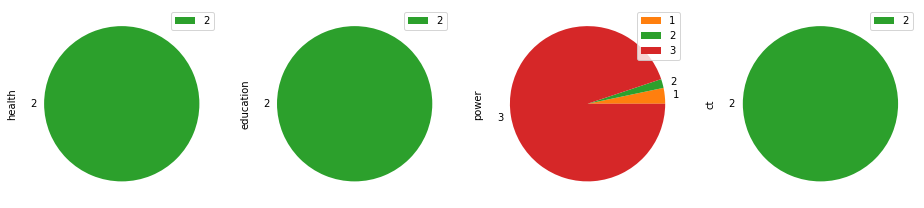

In [78]:
df_all_failmechs_h.plot.pie(subplots=True, figsize=(16, 11))

array([<AxesSubplot: ylabel='health'>, <AxesSubplot: ylabel='education'>,
       <AxesSubplot: ylabel='power'>, <AxesSubplot: ylabel='ct'>],
      dtype=object)

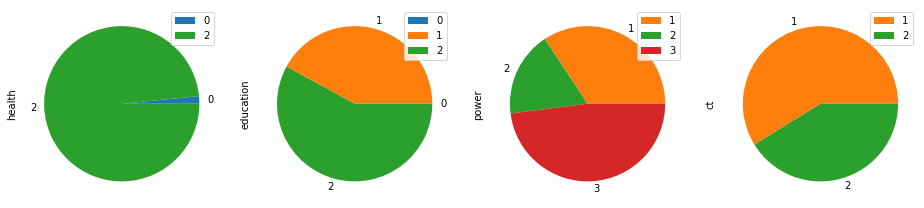

In [79]:
df_all_failmechs_l.plot.pie(subplots=True, figsize=(16, 11))

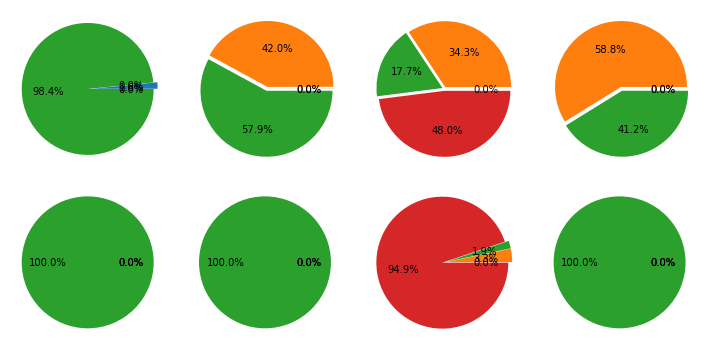

In [81]:
fig, axes = plt.subplots(2,4, figsize=(10, 5), sharex = True, sharey=True)
for ax, service in zip(axes[0,:], df_all_failmechs_l.columns):
    ax.pie(df_all_failmechs_l[service], labels=None, autopct='%1.1f%%', shadow=False, explode=(0.03,0.03,0.03,0.03))

for ax, service in zip(axes[1,:], df_all_failmechs_h.columns):
    ax.pie(df_all_failmechs_h[service], labels=None, autopct='%1.1f%%', shadow=False, explode=(0.03,0.03,0.03,0.03))
fig.tight_layout()


/cluster/apps/nss/gcc-8.2.0/python/3.9.9/x86_64/lib64/python3.9/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


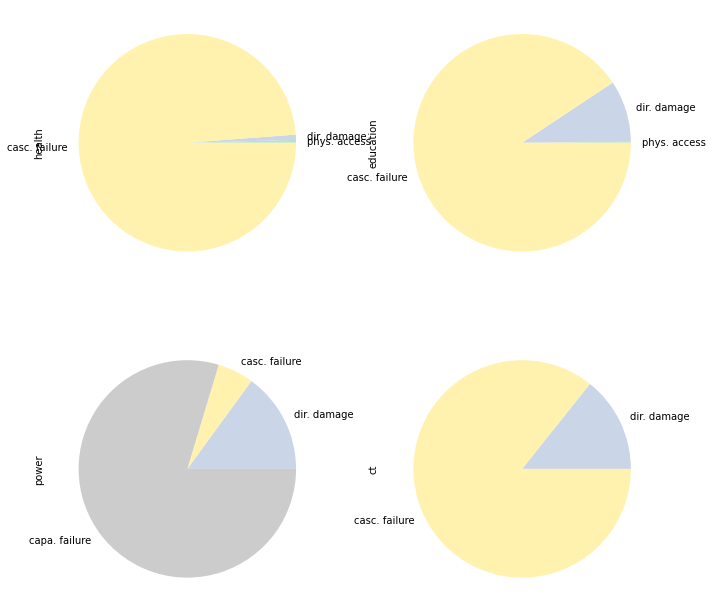

In [124]:
fig, ax = plt.subplots(figsize=(11, 11),)
plot_axes = df_avg_failmech.plot.pie(legend=False, colormap='Pastel2',
                                     subplots=True, ax=ax, xlabel='off', layout=(2,2), ylabel=None)
#handles, labels = plot_axes[0][0].axes.get_legend_handles_labels()
#ax.legend(handles, labels)

In [68]:
gdf_health_sp = get_fail_mech_health_spatial(gdf_higher_event, ci_graph)
gdf_educ_sp = get_fail_mech_educ_spatial(gdf_higher_event, ci_graph)
gdf_pow_sp = get_fail_mech_pow_spatial(gdf_higher_event, ci_graph)
gdf_ct_sp = get_fail_mech_ct_spatial(gdf_higher_event, ci_graph)

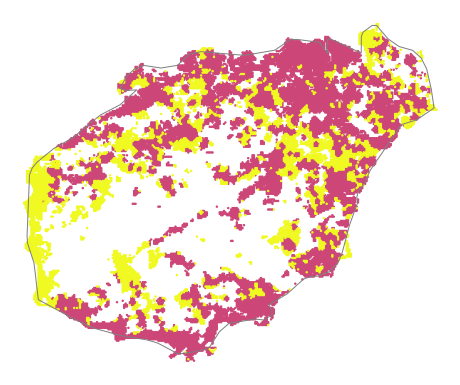

In [69]:
plot_spatial_failmechs(gdf_health_sp, gdf_higher_event, 'healthcare', event_name='TC_Lois', save_path=path_save_plots)

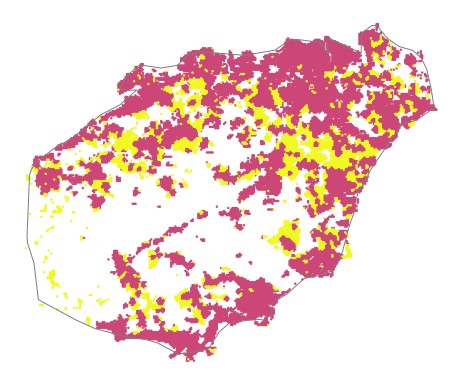

In [70]:
plot_spatial_failmechs(gdf_educ_sp, gdf_higher_event, 'education', event_name='TC_Lois', save_path=path_save_plots)

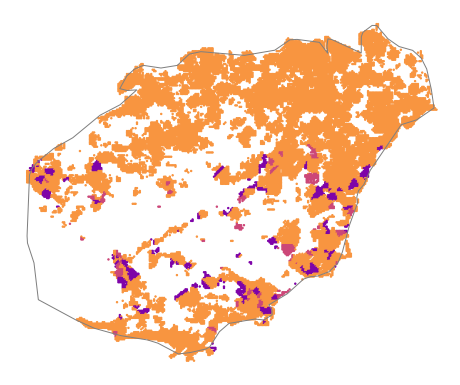

In [71]:
plot_spatial_failmechs(gdf_pow_sp, gdf_higher_event, 'power', event_name='TC_Lois', save_path=path_save_plots)

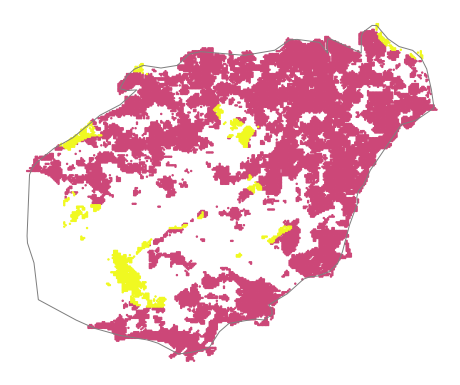

In [72]:
plot_spatial_failmechs(gdf_ct_sp, gdf_higher_event, 'telecom', event_name='TC_Lois', save_path=path_save_plots)

In [73]:
gdf_health_sp = get_fail_mech_health_spatial(gdf_lower_event, ci_graph)
gdf_educ_sp = get_fail_mech_educ_spatial(gdf_lower_event, ci_graph)
gdf_pow_sp = get_fail_mech_pow_spatial(gdf_lower_event, ci_graph)
gdf_ct_sp = get_fail_mech_ct_spatial(gdf_lower_event, ci_graph)

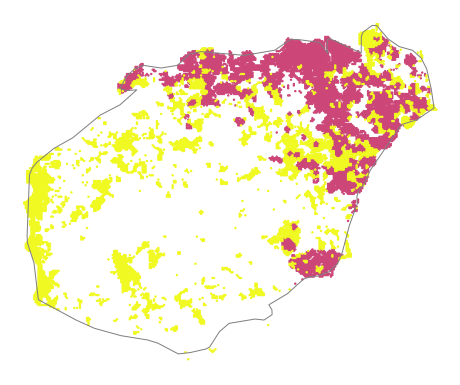

In [74]:
plot_spatial_failmechs(gdf_health_sp, gdf_lower_event, 'healthcare', event_name='TC_Vera', save_path=path_save_plots)

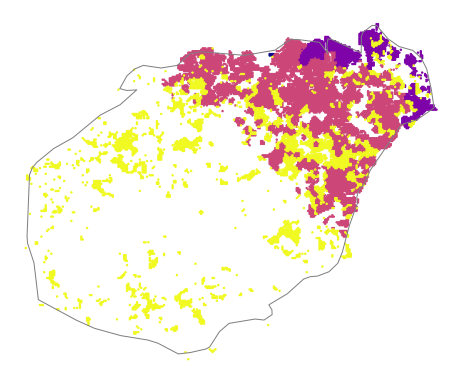

In [75]:
plot_spatial_failmechs(gdf_educ_sp, gdf_lower_event, 'education', event_name='TC_Vera', save_path=path_save_plots)

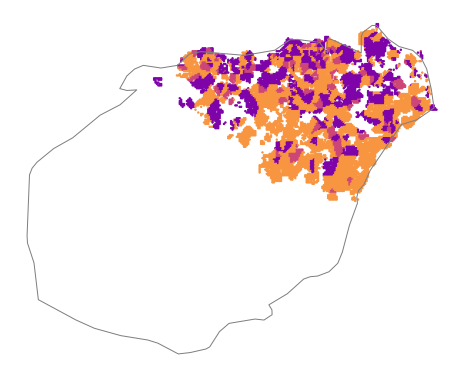

In [76]:
plot_spatial_failmechs(gdf_pow_sp, gdf_lower_event, 'power', event_name='TC_Vera', save_path=path_save_plots)

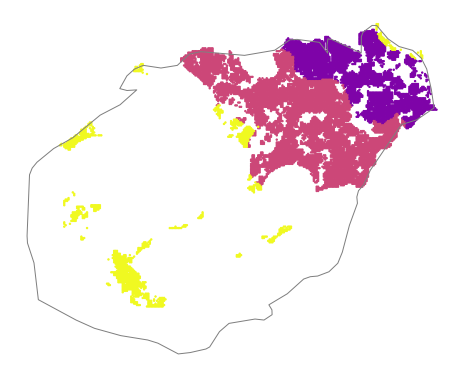

In [77]:
plot_spatial_failmechs(gdf_ct_sp, gdf_lower_event, 'telecom', event_name='TC_Vera', save_path=path_save_plots)

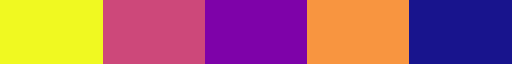

In [2]:
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
cmap = ListedColormap(['#F0F921', "#CD487A", "#7E02A9", "#F89540", '#18148D'])#"magenta", 
cmap


## Exampe: Florida, USA

In [5]:
    # Variable definitions
    cntry = 'USA'
    state = 'Florida'
    haz_type = 'TC'
    iso3 = u_coords.country_to_iso(cntry)

In [126]:
    # average over all events
    df_avg_failmech_fl = wrapper_avg_failmech('USA', state='Florida', haz_type='TC', weight='prop')
    df_avg_failmech_fl

,health,education,power,ct
fail_mech,,,,
phys. access,0.025858,0.000331,0.000000,0.000000
dir. damage,0.323111,0.369018,0.310016,0.507075
casc. failure,0.651031,0.630651,0.081241,0.492925
capa. failure,0.000000,0.000000,0.608742,0.000000


In [6]:
    # Two specific events
    
    # paths
    PATH_ROOT = '/cluster/work/climate/evelynm/nw_outputs/'
    path_cntry_folder = PATH_ROOT+f'{iso3}/'
    path_state_folder = path_cntry_folder+f'{state}/'
    path_save_plots = path_state_folder+'plots/'
    path_nodes = path_state_folder+'cis_nw_nodes'
    path_edges = path_state_folder+'cis_nw_edges'
    gdf_nodes_orig = gpd.read_feather(path_nodes)
    gdf_edges_orig = gpd.read_feather(path_edges)
    ci_network = Network(edges=gdf_edges_orig, 
                         nodes=gdf_nodes_orig)
    ci_graph = Graph(ci_network, directed=True)
    
    lower_disr_event = '1998295N12284' # Hurricane Mitch
    higher_disr_event = '2004223N11301' # Hurricane Charley

    gdf_lower_event = gpd.read_feather(path_state_folder+f'cascade_results_{lower_disr_event}')
    gdf_higher_event = gpd.read_feather(path_state_folder+f'cascade_results_{higher_disr_event}')
    # careful to only run this ones, else overrides the original indexing
    gdf_higher_event = gdf_higher_event.reset_index().rename({'index':'v_id'}, axis=1)
    gdf_lower_event = gdf_lower_event.reset_index().rename({'index':'v_id'}, axis=1)

In [133]:
weights_l, df_all_failmechs_l = get_all_mechs_all(gdf_lower_event, ci_graph)
weights_h, df_all_failmechs_h = get_all_mechs_all(gdf_higher_event, ci_graph)

/cluster/apps/nss/gcc-8.2.0/python/3.9.9/x86_64/lib64/python3.9/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


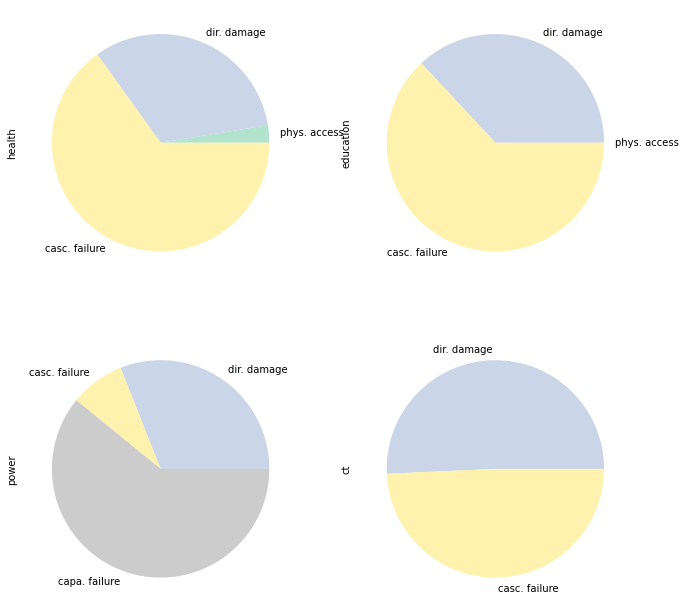

In [129]:
fig, ax = plt.subplots(figsize=(11, 11),)
plot_axes = df_avg_failmech_fl.plot.pie(legend=False, colormap='Pastel2',
                                     subplots=True, ax=ax, xlabel='off', layout=(2,2), ylabel=None)

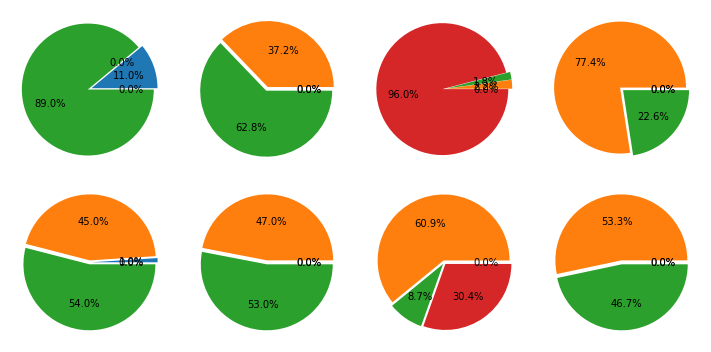

In [134]:
fig, axes = plt.subplots(2,4, figsize=(10, 5), sharex = True, sharey=True)
for ax, service in zip(axes[0,:], df_all_failmechs_l.columns):
    ax.pie(df_all_failmechs_l[service], labels=None, autopct='%1.1f%%', shadow=False, explode=(0.03,0.03,0.03,0.03))

for ax, service in zip(axes[1,:], df_all_failmechs_h.columns):
    ax.pie(df_all_failmechs_h[service], labels=None, autopct='%1.1f%%', shadow=False, explode=(0.03,0.03,0.03,0.03))
fig.tight_layout()


In [20]:
gdf_health_sp = get_fail_mech_health_spatial(gdf_higher_event, ci_graph)
gdf_educ_sp = get_fail_mech_educ_spatial(gdf_higher_event, ci_graph)
gdf_pow_sp = get_fail_mech_pow_spatial(gdf_higher_event, ci_graph)
gdf_ct_sp = get_fail_mech_ct_spatial(gdf_higher_event, ci_graph)

/scratch/tmp.23628183.evelynm/ipykernel_75490/2663519911.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


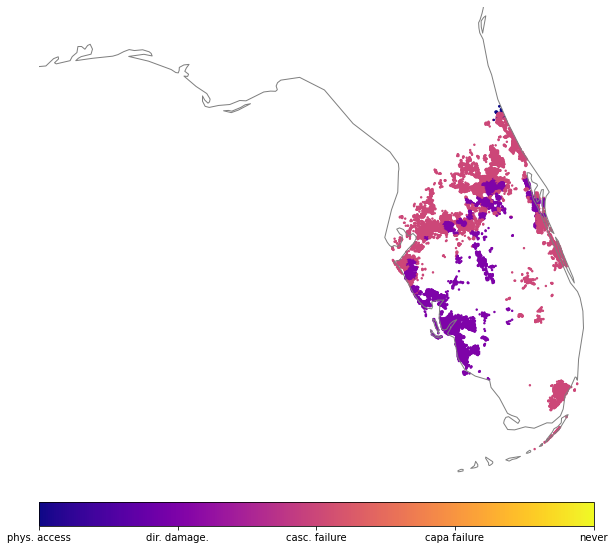

In [21]:
plot_spatial_failmechs(gdf_health_sp, gdf_higher_event, 'healthcare', event_name='TC_Charley', save_path=None)

/scratch/tmp.23628183.evelynm/ipykernel_75490/2663519911.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


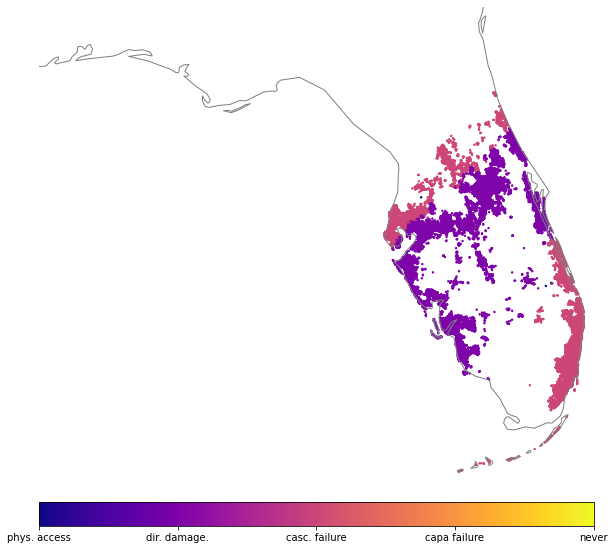

In [22]:
plot_spatial_failmechs(gdf_educ_sp, gdf_higher_event, 'education', event_name='TC_Charley', save_path=None)

/scratch/tmp.23628183.evelynm/ipykernel_75490/2663519911.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


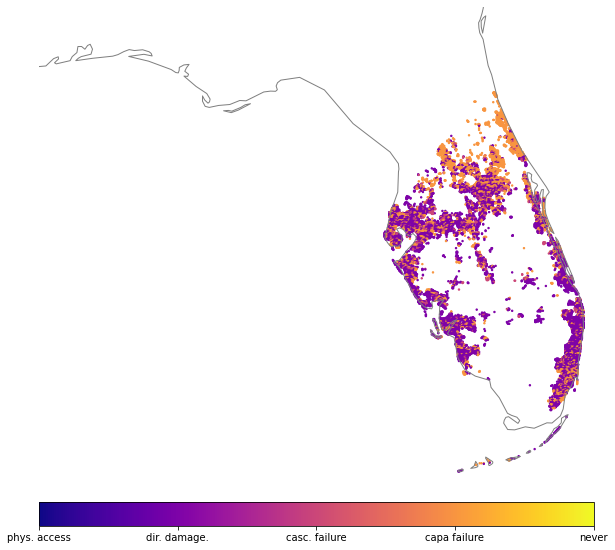

In [29]:
plot_spatial_failmechs(gdf_pow_sp, gdf_higher_event, 'power', event_name='TC_Charley', save_path=None)

/scratch/tmp.23628183.evelynm/ipykernel_75490/2663519911.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


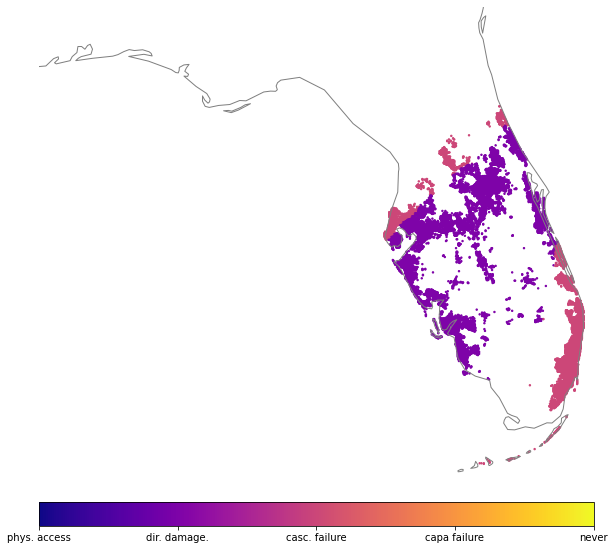

In [24]:
plot_spatial_failmechs(gdf_ct_sp, gdf_higher_event, 'mobile comms', event_name='TC_Charley', save_path=None)

In [9]:
gdf_health_sp = get_fail_mech_health_spatial(gdf_lower_event, ci_graph)
gdf_educ_sp = get_fail_mech_educ_spatial(gdf_lower_event, ci_graph)
gdf_pow_sp = get_fail_mech_pow_spatial(gdf_lower_event, ci_graph)
gdf_ct_sp = get_fail_mech_ct_spatial(gdf_lower_event, ci_graph)

/scratch/tmp.23730450.evelynm/ipykernel_23180/2663519911.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


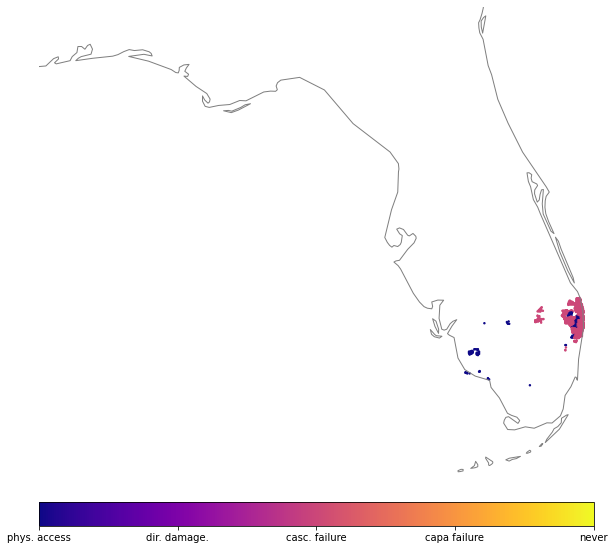

In [10]:
plot_spatial_failmechs(gdf_health_sp, gdf_higher_event, 'healthcare', event_name='TC_Mitch', save_path=None)

/scratch/tmp.23730450.evelynm/ipykernel_23180/2663519911.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


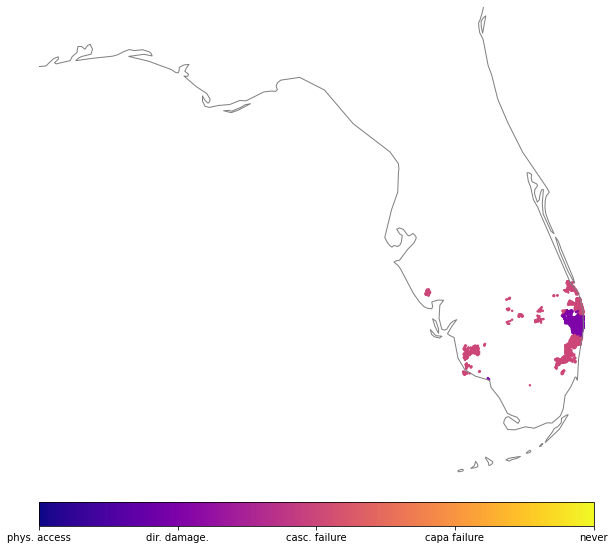

In [11]:
plot_spatial_failmechs(gdf_educ_sp, gdf_higher_event, 'education', event_name='TC_Charley', save_path=None)

/scratch/tmp.23730450.evelynm/ipykernel_23180/2663519911.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


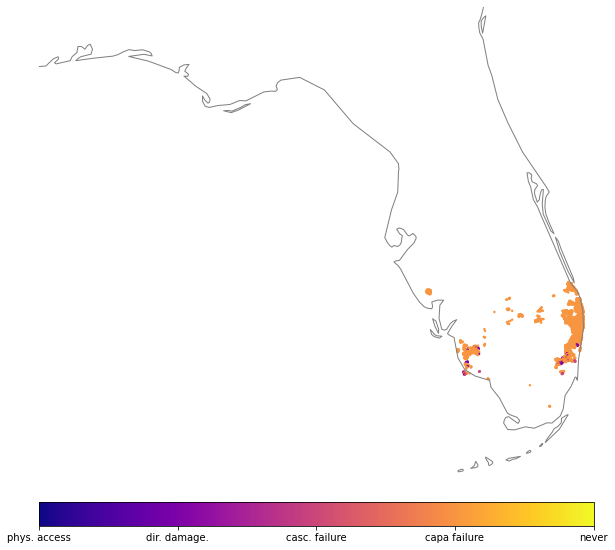

In [12]:
plot_spatial_failmechs(gdf_pow_sp, gdf_higher_event, 'power', event_name='TC_Charley', save_path=None)

/scratch/tmp.23730450.evelynm/ipykernel_23180/2663519911.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


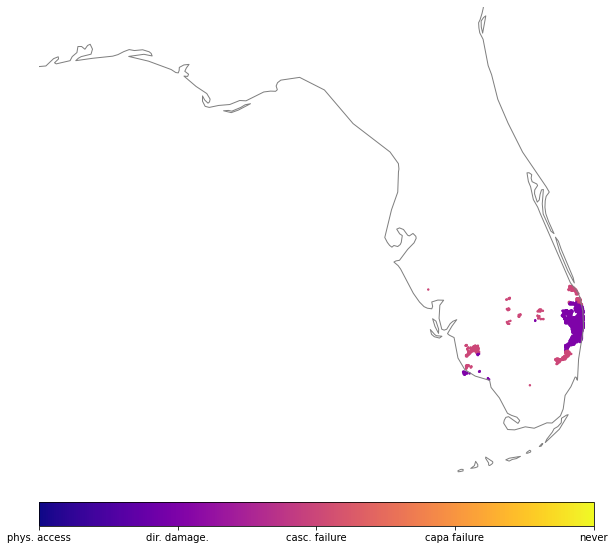

In [13]:
plot_spatial_failmechs(gdf_ct_sp, gdf_higher_event, 'mobile comms', event_name='TC_Charley', save_path=None)

## Example: Mozambique

In [128]:
    # Variable definitions
    cntry = 'Mozambique'
    state = None
    haz_type = 'TC'
    iso3 = u_coords.country_to_iso(cntry)

In [136]:
    # average over all events
    df_avg_failmech_moz = wrapper_avg_failmech(cntry, state=state, haz_type='TC', weight='prop')
    df_avg_failmech_moz

,health,education,power,ct
fail_mech,,,,
phys. access,0.025858,0.000331,0.000000,0.000000
dir. damage,0.323111,0.369018,0.310016,0.507075
casc. failure,0.651031,0.630651,0.081241,0.492925
capa. failure,0.000000,0.000000,0.608742,0.000000


/cluster/apps/nss/gcc-8.2.0/python/3.9.9/x86_64/lib64/python3.9/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


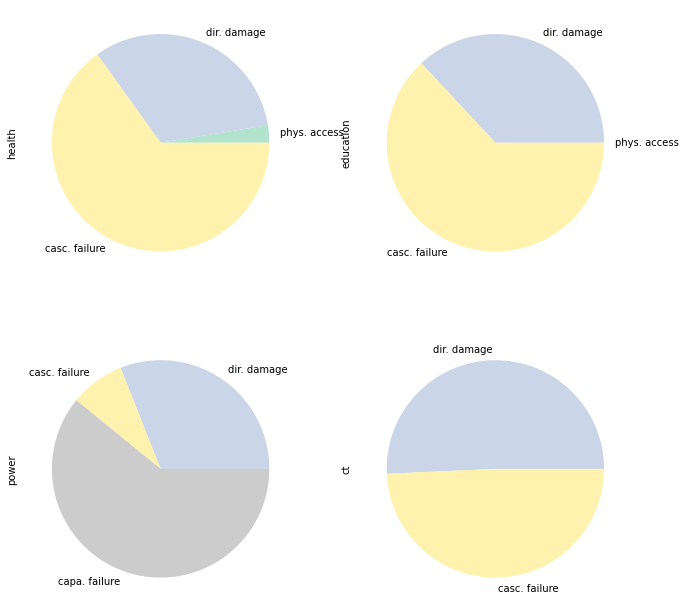

In [137]:
fig, ax = plt.subplots(figsize=(11, 11),)
plot_axes = df_avg_failmech_moz.plot.pie(legend=False, colormap='Pastel2',
                                     subplots=True, ax=ax, xlabel='off', layout=(2,2), ylabel=None)

## All countries (TC)

In [9]:
# all countries (will take a while):
haz_type = 'TC'
 
dict_failmech_allregs = {}

for iso3 in ['ATG', 'BGD', 'CUB', 'GTM', 'HTI', 'KHM','LKA','MDG', 'MEX', 'MOZ', 'PHL', 'VNM', 'PRI']:  
    print(iso3)
    dict_failmech_allregs[iso3] = wrapper_avg_failmech(iso3, state=None, haz_type=haz_type, weight='prop')

for iso3, state in zip(['USA','USA', 'USA', 'CHN', 'CHN'], ['Florida', 'Louisiana', 'Texas', 'Fujian', 'Hainan']) :
    print(iso3, state)
    dict_failmech_allregs[f'{iso3} {state}'] = wrapper_avg_failmech(iso3, state=state, haz_type=haz_type, weight='prop')

MDG
MEX
MOZ
PHL
VNM
PRI
USA Florida
USA Louisiana
USA Texas
CHN Fujian
CHN Hainan


In [10]:
# plot all regs in stacked barcharts.
#af.save_dict(dict_failmech_allregs, PATH_ROOT+'comp_results/failmechs_allregs_TC.pkl')
#dict_failmech_allregs

{'ATG':                health  education     power        ct
 fail_mech                                           
 phys. access     0.00   0.000000  0.000000  0.000000
 dir. damage      0.25   0.862159  0.723918  0.950516
 casc. failure    0.75   0.137841  0.156599  0.049484
 capa. failure    0.00   0.000000  0.119482  0.000000,
 'BGD':                  health  education     power        ct
 fail_mech                                             
 phys. access   0.024463   0.014011  0.000000  0.000000
 dir. damage    0.390235   0.391798  0.096170  0.470381
 casc. failure  0.585302   0.594191  0.031365  0.529619
 capa. failure  0.000000   0.000000  0.872465  0.000000,
 'CUB':                  health  education     power       ct
 fail_mech                                            
 phys. access   0.028876   0.000421  0.000000  0.00000
 dir. damage    0.216522   0.358320  0.354655  0.50174
 casc. failure  0.754602   0.641259  0.078364  0.49826
 capa. failure  0.000000   0.000000  0.566

In [8]:
PATH_RESULTS = '/Users/evelynm/Documents/WCR/3_PhD/1_coding_stuff/x_data/result_data'
# PATH_ROOT+'comp_results/failmechs_allregs_TC.pkl' -> on cluster
dict_failmech_allregs = af.load_dict(PATH_RESULTS+'/failmechs_allregs_TC.pkl')
dict_failmech_allregs

{'ATG':                health  education     power        ct
 fail_mech                                           
 phys. access     0.00   0.000000  0.000000  0.000000
 dir. damage      0.25   0.862159  0.723918  0.950516
 casc. failure    0.75   0.137841  0.156599  0.049484
 capa. failure    0.00   0.000000  0.119482  0.000000,
 'BGD':                  health  education     power        ct
 fail_mech                                             
 phys. access   0.024463   0.014011  0.000000  0.000000
 dir. damage    0.390235   0.391798  0.096170  0.470381
 casc. failure  0.585302   0.594191  0.031365  0.529619
 capa. failure  0.000000   0.000000  0.872465  0.000000,
 'CUB':                  health  education     power       ct
 fail_mech                                            
 phys. access   0.028876   0.000421  0.000000  0.00000
 dir. damage    0.216522   0.358320  0.354655  0.50174
 casc. failure  0.754602   0.641259  0.078364  0.49826
 capa. failure  0.000000   0.000000  0.566

In [19]:
# Stats
all_fail_mechs = pd.concat(list(dict_failmech_allregs.values()))


In [25]:
all_fail_mechs.groupby('fail_mech').agg({'health':['mean', 'std'],
                                        'education':['mean', 'std'],
                                        'power':['mean', 'std'],
                                        'ct':['mean', 'std']})

health           education               power            \
                   mean       std      mean       std      mean       std   
fail_mech                                                                   
capa. failure  0.000000  0.000000  0.000000  0.000000  0.708104  0.204563   
casc. failure  0.835602  0.148027  0.727046  0.225089  0.058701  0.038092   
dir. damage    0.141147  0.143826  0.270938  0.225036  0.233196  0.170428   
phys. access   0.023251  0.024282  0.002017  0.003762  0.000000  0.000000   

                     ct           
                   mean      std  
fail_mech                         
capa. failure  0.000000  0.00000  
casc. failure  0.636653  0.27083  
dir. damage    0.363347  0.27083  
phys. access   0.000000  0.00000

In [12]:
# Plot all

In [13]:
from matplotlib.patches import Patch

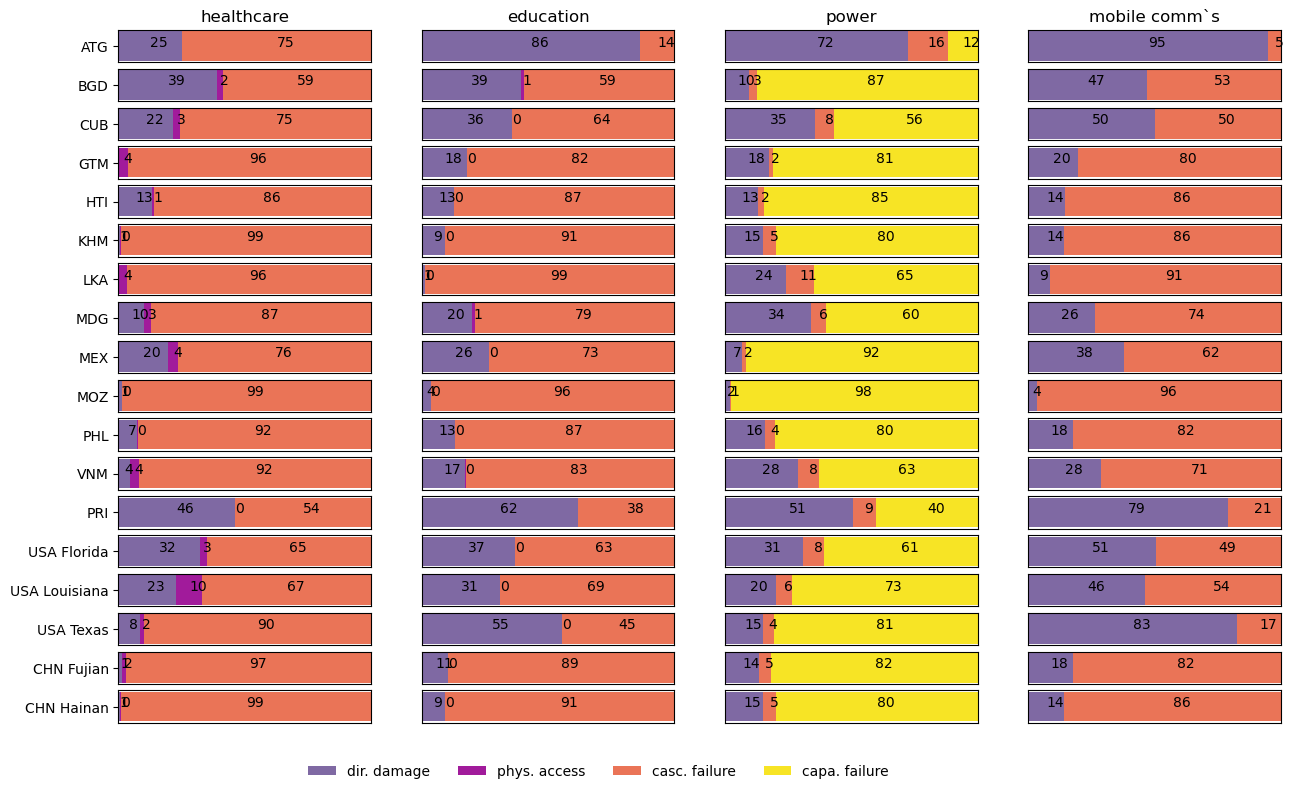

In [24]:
    reg_names =list(dict_failmech_allregs.keys())
    category_names = ['dir. damage','phys. access', 'casc. failure', 'capa. failure']
    service_names = list(dict_failmech_allregs.values())[0].columns
    category_colors = plt.colormaps['plasma'](np.linspace(0.05, 0.95, len(service_names)))
    # replace first color by a lighter tone
    category_colors[0][-1] = 0.6
    category_colors[0][-2] = 0.4
    
    fig, axes = plt.subplots(len(dict_failmech_allregs.keys()), len(service_names), sharex=True,
                             figsize=(15,0.5*len(dict_failmech_allregs.keys())))
    for row, (key, data) in enumerate(dict_failmech_allregs.items()): 
        data = data.reindex(category_names, fill_value=0)
        for service, ax in zip(service_names, axes[row,:]):
            widths = data[service].values
            data_cum = widths.cumsum()
            #ax.axis('off')
            ax.set_xlim(0, 1)
            ax.set_xticks([])
            ax.set_yticks([])
            for i, (colname, color) in enumerate(zip(category_names, category_colors)):
                starts = data_cum[i] - widths[i]
                rects = ax.barh(0.5, widths[i], left=starts, height=0.5, label=widths[i], color=color)
                if widths[i]>0:
                    ax.annotate(str(int(np.round(widths[i],2)*100)), (starts+widths[i]/2, 0.5))
        axes[row, 0].set_yticks([0.5])
        axes[row, 0].set_yticklabels([key])
        
    axes[0, 0].set_title('healthcare')
    axes[0, 1].set_title('education')    
    axes[0, 2].set_title('power')    
    axes[0, 3].set_title('mobile comm`s')    


    legend_elements = [Patch(facecolor=category_colors[0], edgecolor=None, label=category_names[0]),
                       Patch(facecolor=category_colors[1], edgecolor=None, label=category_names[1]),
                       Patch(facecolor=category_colors[2], edgecolor=None, label=category_names[2]),
                       Patch(facecolor=category_colors[3], edgecolor=None, label=category_names[3])]

    axes[-1,-2].legend(handles=legend_elements, loc='center', ncols=4, bbox_to_anchor=(-0.5,-1.5), frameon=False)
    
    plt.savefig(PATH_RESULTS+'/failmechs_allregs_TC.pdf')# PATH_ROOT+'comp_results/failmechs_allregs_TC.pdf', dpi=300
    plt.show()



## All countries (FL)

In [ ]:
# all countries (will take a while):
haz_type = 'FL'
dict_failmech_allregs_fl = {}

for iso3 in ['PHL', 'VNM', 'BGD','GRC', 'HUN', 'HTI', 'GBR', 'URY', 'MOZ', 'LKA', 'BDI', 'CUB', 'TJK', 'MDG', 'MEX','KHM', 'SRB', 'GTM', 'CHE', 'NLD', 'CHL', 'GEO']:
    print(iso3)
    dict_failmech_allregs_fl[iso3] = wrapper_avg_failmech(iso3, state=None, haz_type=haz_type, weight='prop')

for iso3, state in set(zip(['USA', 'USA','CHN'],['Florida', 'Texas', 'Fujian'])):
    print(iso3, state)
    dict_failmech_allregs_fl[f'{iso3} {state}'] = wrapper_avg_failmech(iso3, state=state, haz_type=haz_type, weight='prop')

In [28]:
# plot all regs in stacked barcharts.
af.save_dict(dict_failmech_allregs_fl, PATH_ROOT+'comp_results/failmechs_allregs_FL.pkl')
dict_failmech_allregs_fl

{'BDI':                 health  education  power   ct
 fail_mech                                    
 phys. access   0.99967   0.999993    0.0  0.0
 dir. damage    0.00000   0.000000    0.0  0.0
 casc. failure  0.00000   0.000000    0.0  0.0
 capa. failure  0.00000   0.000000    0.0  0.0,
 'BGD':                  health  education     power        ct
 fail_mech                                             
 phys. access   0.887210   0.229785  0.000000  0.000000
 dir. damage    0.042115   0.375123  0.000000  0.460575
 casc. failure  0.070675   0.395091  0.000000  0.539411
 capa. failure  0.000000   0.000000  0.999999  0.000000,
 'CHE':                  health  education  power   ct
 fail_mech                                     
 phys. access   0.987805   0.013185    0.0  0.0
 dir. damage    0.012195   0.986815    0.0  0.0
 casc. failure  0.000000   0.000000    0.0  0.0
 capa. failure  0.000000   0.000000    0.0  0.0,
 'CHL':                  health  education  power   ct
 fail_mech     

In [25]:
dict_failmech_allregs_fl = af.load_dict(PATH_RESULTS+'/failmechs_allregs_FL.pkl') #PATH_ROOT+'comp_results/failmechs_allregs_FL.pkl'
sorted_keys = list(dict_failmech_allregs_fl.keys())
sorted_keys.sort()
dict_failmech_allregs_fl = {key: dict_failmech_allregs_fl[key] for key in sorted_keys}

In [34]:
# Stats
all_fail_mechs_fl = pd.concat(list(dict_failmech_allregs_fl.values()))


In [39]:
all_fail_mechs_fl.loc['phys. access','health'].mean()

0.894075912225777

In [35]:
all_fail_mechs_fl.groupby('fail_mech').agg({'health':['mean', 'std'],
                                        'education':['mean', 'std'],
                                        'power':['mean', 'std'],
                                        'ct':['mean', 'std']})

health           education               power            \
                   mean       std      mean       std      mean       std   
fail_mech                                                                   
capa. failure  0.000000  0.000000  0.000000  0.000000  0.749531  0.442051   
casc. failure  0.084560  0.213688  0.221580  0.251965  0.000000  0.000000   
dir. damage    0.021190  0.075244  0.413286  0.310618  0.000000  0.000000   
phys. access   0.894076  0.239534  0.365014  0.360385  0.000000  0.000000   

                     ct            
                   mean       std  
fail_mech                          
capa. failure  0.000000  0.000000  
casc. failure  0.200500  0.336759  
dir. damage    0.132373  0.257717  
phys. access   0.000000  0.000000

In [33]:
# Plot all

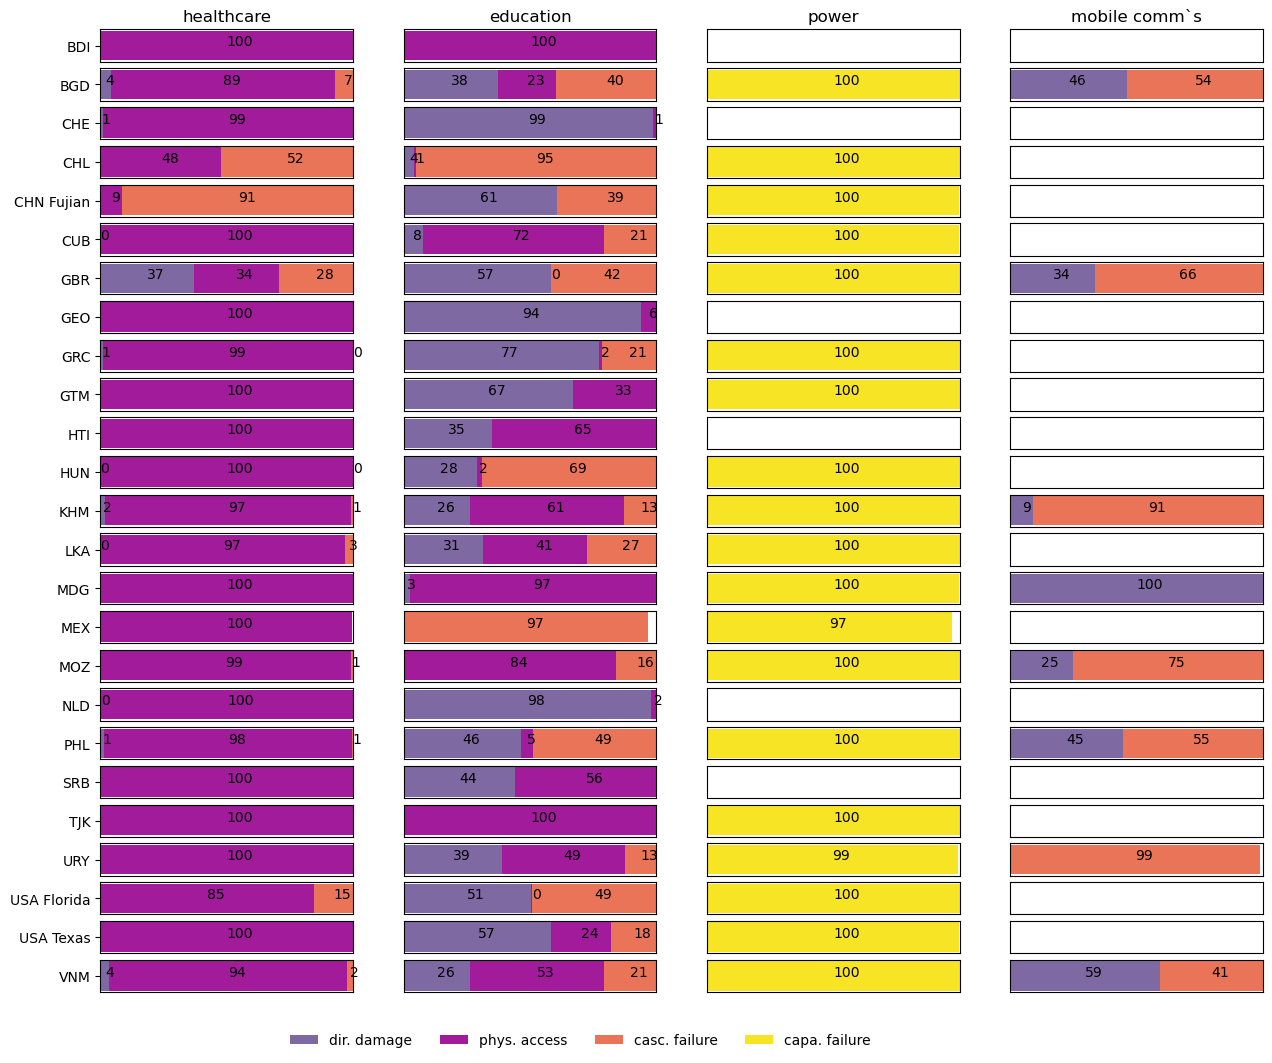

In [26]:
    reg_names =list(dict_failmech_allregs_fl.keys())
    category_names = ['dir. damage','phys. access', 'casc. failure', 'capa. failure']
    service_names = list(dict_failmech_allregs_fl.values())[0].columns
    category_colors = plt.colormaps['plasma'](np.linspace(0.05, 0.95, len(service_names)))
    # replace first color by a lighter tone
    category_colors[0][-1] = 0.6
    category_colors[0][-2] = 0.4
    
    fig, axes = plt.subplots(len(dict_failmech_allregs_fl.keys()), len(service_names), sharex=True,
                             figsize=(15,0.5*len(dict_failmech_allregs_fl.keys())))
    for row, (key, data) in enumerate(dict_failmech_allregs_fl.items()): 
        data = data.reindex(category_names, fill_value=0)
        for service, ax in zip(service_names, axes[row,:]):
            widths = data[service].values
            data_cum = widths.cumsum()
            #ax.axis('off')
            ax.set_xlim(0, 1)
            ax.set_xticks([])
            ax.set_yticks([])
            for i, (colname, color) in enumerate(zip(category_names, category_colors)):
                starts = data_cum[i] - widths[i]
                rects = ax.barh(0.5, widths[i], left=starts, height=0.5, label=widths[i], color=color)
                if widths[i]>0:
                    ax.annotate(str(int(np.round(widths[i],2)*100)), (starts+widths[i]/2, 0.5))
        axes[row, 0].set_yticks([0.5])
        axes[row, 0].set_yticklabels([key])
        
    axes[0, 0].set_title('healthcare')
    axes[0, 1].set_title('education')    
    axes[0, 2].set_title('power')    
    axes[0, 3].set_title('mobile comm`s')    


    legend_elements = [Patch(facecolor=category_colors[0], edgecolor=None, label=category_names[0]),
                       Patch(facecolor=category_colors[1], edgecolor=None, label=category_names[1]),
                       Patch(facecolor=category_colors[2], edgecolor=None, label=category_names[2]),
                       Patch(facecolor=category_colors[3], edgecolor=None, label=category_names[3])]

    axes[-1,-2].legend(handles=legend_elements, loc='center', ncols=4, bbox_to_anchor=(-0.5,-1.5), frameon=False)
    plt.savefig(PATH_RESULTS+'/failmechs_allregs_FL.pdf')# PATH_ROOT+'comp_results/failmechs_allregs_FL.png', dpi=300
    plt.show()


### Imps vs. disruptions

In [151]:
def spillover_impact_plot(gdf, service, service_base, vmin, save_path=None):
    """
    per basic service, people cluster with and without access to that service
    """
    border = cfeature.NaturalEarthFeature('cultural', 'admin_0_countries', '50m')
    f, ax = plt.subplots(1,1, subplot_kw=dict(projection=ccrs.PlateCarree()),figsize=(8,8))
    
    ax.set_extent(_get_extent(gdf), ccrs.PlateCarree())
    ax.add_feature(border, facecolor='none', edgecolor='0.5')
    ax.axis('off')

    h_serv = ax.scatter(gdf.geometry.x, gdf.geometry.y, 
                            c=gdf[service],
                            cmap='BrBG', 
                            transform=ccrs.PlateCarree(), 
                             s=0.2, vmin=vmin, vmax=-1*vmin,)#
    ax.scatter(gdf[gdf[service_base]==0].geometry.x, gdf[gdf[service_base]==0].geometry.y, 
                            c='gray',
                            transform=ccrs.PlateCarree(), 
                             s=0.2)
          
    cbar = mpu.colorbar(
        h_serv, ax, size=0.05, pad=0.05, orientation='horizontal', extendrect=True)  
    cbar.set_ticks([vmin+1, abs(vmin+1)])
    cbar.set_ticklabels(['More disr.', 'Less disr.'])

  
    #f.suptitle(f'Service Disruptions from event {event_name}', weight='bold', fontsize=24)
    f.subplots_adjust(bottom=0.05, top=0.95)  
    f.tight_layout()                                
    if save_path:
        plt.savefig(f'{save_path}'+f'spillover_impacts.png', 
        bbox_inches='tight', pad_inches=0.1, dpi=300,
        facecolor='auto', edgecolor='auto',
        backend=None)

In [93]:
    iso3='USA'
    state='Louisiana'
    haz_type ='TC'
    PATH_ROOT = '/cluster/work/climate/evelynm/nw_outputs/'
    path_cntry_folder = PATH_ROOT+f'{iso3}/'
    path_state_folder = path_cntry_folder+f'{state}/'
    path_save_plots = path_state_folder+'plots/'

In [42]:
tot_imps = gpd.read_feather(path_state_folder+f'summed_pop_impacts_{haz_type}_{iso3}_{state}')

In [57]:
tot_imps

,actual_supply_celltower_people,actual_supply_education_people,actual_supply_health_people,actual_supply_power_line_people,actual_supply_road_people,imp_dir,counts,geometry,lat,lon
7252,-97.636696,-97.636696,97.636696,-97.636696,97.636696,-0.000000,97.636696,POINT (-92.73042 33.01208),33.012083,-92.730416
7253,-353.496033,-353.496033,353.496033,-353.496033,353.496033,-0.000000,353.496033,POINT (-92.72208 33.01208),33.012083,-92.722083
7254,-205.291412,-205.291412,205.291412,-205.291412,205.291412,-0.000000,205.291412,POINT (-92.71375 33.01208),33.012083,-92.713750
7255,-20.537443,-20.537443,20.537443,-20.537443,20.537443,-0.000000,20.537443,POINT (-92.66375 33.01208),33.012083,-92.663750
7256,-22.505520,-45.011040,-22.505520,-45.011040,-22.505520,-22.505520,22.505520,POINT (-94.01375 33.00375),33.003750,-94.013750
...,...,...,...,...,...,...,...,...,...,...
30158,-176.007980,-176.007980,-176.007980,-176.007980,-88.003990,-176.007980,29.334663,POINT (-90.00542 29.23708),29.237083,-90.005416
30159,-878.457001,-878.457001,-878.457001,-878.457001,-439.228500,-878.457001,146.409500,POINT (-89.99708 29.23708),29.237083,-89.997083
30160,-135.247993,-135.247993,-135.247993,-135.247993,-135.247993,-135.247993,22.541332,POINT (-90.01375 29.22875),29.228750,-90.013750
30161,-353.113655,-353.113655,-353.113655,-353.113655,-353.113655,-353.113655,58.852276,POINT (-90.02208 29.22042),29.220417,-90.022083


In [128]:
# normalize by population count per cluster
tot_imps_norm = tot_imps.iloc[:,[0,1,2,3,4,5]].values/tot_imps['counts'].values[np.newaxis].T
max_imp = np.min(tot_imps_norm[:,-1])

In [129]:
max_imp

-9.0

In [102]:
# base access (correct for no access in )
base_access = ~(tot_imps_norm[:,2]==0)*1
base_access

array([1, 1, 1, ..., 1, 1, 1])

In [103]:
tot_imps_rel = tot_imps_norm[:,:-1]-tot_imps_norm[:,-1][np.newaxis].T

In [107]:
tot_imps['hc_vs_imp'] = tot_imps_rel[:,2]*base_access
tot_imps['hc_base'] = base_access

<AxesSubplot: >

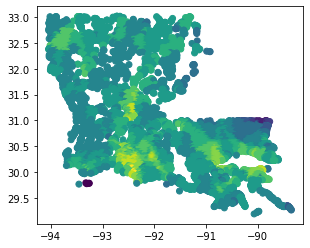

In [105]:
tot_imps.plot('hc_vs_imp')

/scratch/tmp.27165370.evelynm/ipykernel_37279/620191655.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


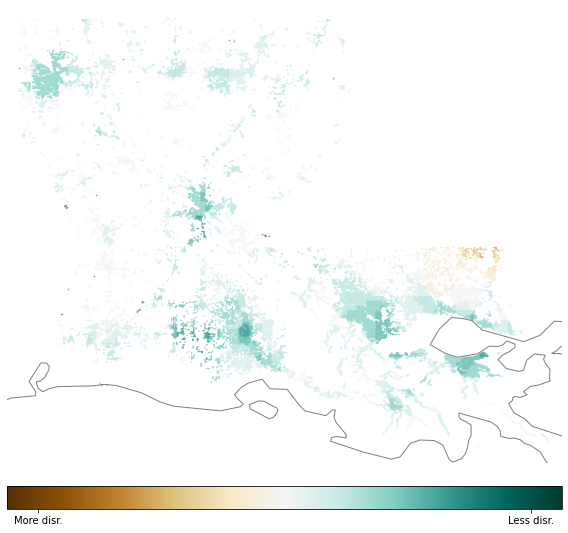

In [152]:
spillover_impact_plot(tot_imps, 'hc_vs_imp', 'hc_base', max_imp, save_path=path_save_plots)

In [78]:
# Madagascar

In [144]:
    iso3='MDG'
    haz_type ='TC'
    PATH_ROOT = '/cluster/work/climate/evelynm/nw_outputs/'
    path_cntry_folder = PATH_ROOT+f'{iso3}/'
    path_save_plots_mdg = path_cntry_folder+'plots/'

In [80]:
tot_imps_mdg = gpd.read_feather(path_cntry_folder+f'summed_pop_impacts_{haz_type}_{iso3}')

In [132]:
tot_imps_norm_mdg = tot_imps_mdg.iloc[:,[0,1,2,3,4,5]].values/tot_imps_mdg['counts'].values[np.newaxis].T
max_imp_mdg = np.min(tot_imps_norm_mdg[:,-1])

In [133]:
tot_imps_rel_mdg = tot_imps_norm_mdg[:,:-1]-tot_imps_norm_mdg[:,-1][np.newaxis].T

In [134]:
# base access (correct for no access in )
base_access = ~(tot_imps_norm_mdg[:,2]==0)*1
base_access

array([0, 0, 0, ..., 0, 0, 0])

In [135]:
tot_imps_rel_mdg = tot_imps_norm_mdg[:,:-1]-tot_imps_norm_mdg[:,-1][np.newaxis].T

In [136]:
tot_imps_mdg['hc_vs_imp'] = tot_imps_rel_mdg[:,2]*base_access
tot_imps_mdg['hc_base'] = base_access

/scratch/tmp.27165370.evelynm/ipykernel_37279/620191655.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


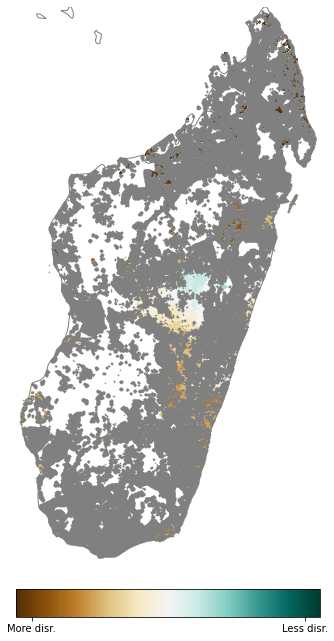

In [153]:
spillover_impact_plot(tot_imps_mdg, 'hc_vs_imp', 'hc_base', max_imp_mdg, save_path=path_save_plots_mdg)